# Image features exercise

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. Now we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

In [32]:
import random
import numpy as np
import matplotlib.pyplot as plt

from utils.data_utils import get_CIFAR10_data

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
temp = np.array([[1,2,3],[2,4,6],[3,6,9]])

In [54]:
np.diff(temp, n=1, axis=1)

array([[1, 1],
       [2, 2],
       [3, 3]])

In [52]:
np.diff(temp, n=1, axis=0)

array([[1, 2, 3],
       [1, 2, 3]])

In [ ]:
np.arctan2()

## Load data

We will load CIFAR-10 data from disk.

In [33]:
from utils.features import color_histogram_hsv, hog_feature

cifar10_dataset = get_CIFAR10_data(cifar10_dir='./datasets/cifar-10-batches-py')

X_train = cifar10_dataset['X_train']
y_train = cifar10_dataset['y_train']
X_dev = cifar10_dataset['X_dev']
y_dev = cifar10_dataset['y_dev']
X_val = cifar10_dataset['X_val']
y_val = cifar10_dataset['y_val']
X_test = cifar10_dataset['X_test']
y_test = cifar10_dataset['y_test']

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Dev data shape: ', X_dev.shape)
print('Dev labels shape: ', y_dev.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (49000, 32, 32, 3)
Training labels shape:  (49000,)
Dev data shape:  (5000, 32, 32, 3)
Dev labels shape:  (5000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


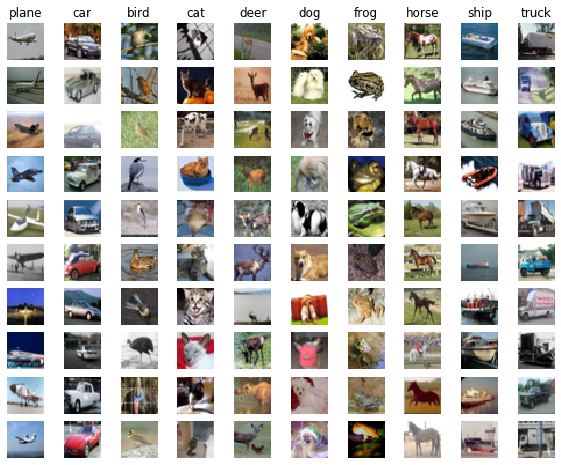

In [34]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The `extract_features`
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [35]:
from utils.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]

X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_dev_feats = extract_features(X_dev, feature_fns)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [36]:
print('Training data shape: ', X_train_feats.shape)
print('Dev data shape: ', X_dev_feats.shape)
print('Validation data shape: ', X_val_feats.shape)
print('Test data shape: ', X_test_feats.shape)

Training data shape:  (49000, 154)
Dev data shape:  (5000, 154)
Validation data shape:  (1000, 154)
Test data shape:  (10000, 154)


In [37]:
# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_dev_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_dev_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_dev_feats = np.hstack([X_dev_feats, np.ones((X_dev_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

## Train SVM on features
Using the multiclass SVM code developed earlier, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [38]:
# Use the validation set to tune the learning rate and regularization strength

from classifiers.linear_classifier import LinearSVM

learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]
regularization_strengths = [1e-3, 1e-2, 1e-1, 1e0, 1e1]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=learning_rate, reg=regularization_strength, 
                  num_iters=1500, verbose=False)
        train_accuracy = np.mean(y_train == svm.predict(X_train_feats))
        val_accuracy = np.mean(y_val == svm.predict(X_val_feats))

        if best_val < val_accuracy:
            best_val = val_accuracy
            best_svm = svm

        results[(learning_rate, regularization_strength)] = (train_accuracy, val_accuracy)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-05 reg 1.000000e-03 train accuracy: 0.409898 val accuracy: 0.413000
lr 1.000000e-05 reg 1.000000e-02 train accuracy: 0.407531 val accuracy: 0.409000
lr 1.000000e-05 reg 1.000000e-01 train accuracy: 0.409122 val accuracy: 0.399000
lr 1.000000e-05 reg 1.000000e+00 train accuracy: 0.411714 val accuracy: 0.410000
lr 1.000000e-05 reg 1.000000e+01 train accuracy: 0.411796 val accuracy: 0.421000
lr 1.000000e-04 reg 1.000000e-03 train accuracy: 0.451531 val accuracy: 0.445000
lr 1.000000e-04 reg 1.000000e-02 train accuracy: 0.451551 val accuracy: 0.440000
lr 1.000000e-04 reg 1.000000e-01 train accuracy: 0.450673 val accuracy: 0.448000
lr 1.000000e-04 reg 1.000000e+00 train accuracy: 0.449429 val accuracy: 0.445000
lr 1.000000e-04 reg 1.000000e+01 train accuracy: 0.428980 val accuracy: 0.431000
lr 1.000000e-03 reg 1.000000e-03 train accuracy: 0.498878 val accuracy: 0.487000
lr 1.000000e-03 reg 1.000000e-02 train accuracy: 0.501510 val accuracy: 0.488000
lr 1.000000e-03 reg 1.000000

In [39]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.4943


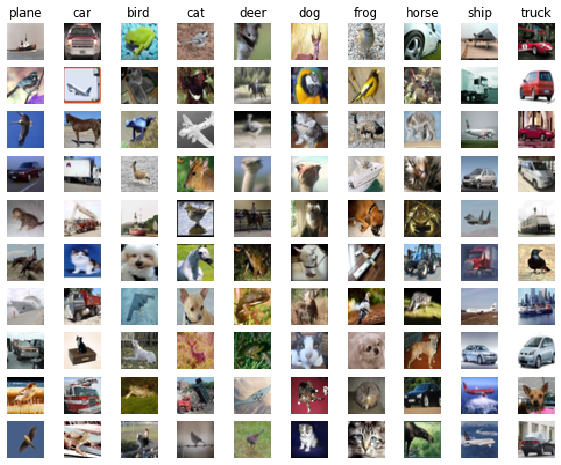

In [31]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [40]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)

X_train_feats = X_train_feats[:, :-1]
X_dev_feats = X_dev_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [46]:
from classifiers.neural_net import TwoLayerNet

best_net = None # store the best model into this 
best_val = -1
results = {}

input_dim = X_train_feats.shape[1]
hidden_size = 500
num_classes = 10

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
model_count = 10
for count in np.arange(model_count):
    lr = 10 ** np.random.uniform(-1, 0)
    reg = 10 ** np.random.uniform(-5, -3)
    
    net = TwoLayerNet(input_dim, hidden_size, num_classes)

    # Train the network
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=1000, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=reg, verbose=False)
    
    # Predict on the training set
    train_accuracy = np.mean(net.predict(X_train_feats) == y_train)
    
    # Predict on the validation set
    val_accuracy = np.mean(net.predict(X_val_feats) == y_val)
    
    if best_val < val_accuracy:
        best_val = val_accuracy
        best_net = net
        
    results[(lr, reg)] = (train_accuracy, val_accuracy)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.759562e-01 reg 2.893718e-05 train accuracy: 0.552102 val accuracy: 0.534000
lr 2.003312e-01 reg 2.493298e-05 train accuracy: 0.559122 val accuracy: 0.545000
lr 2.097779e-01 reg 9.150755e-05 train accuracy: 0.564388 val accuracy: 0.554000
lr 2.689478e-01 reg 9.852999e-04 train accuracy: 0.574041 val accuracy: 0.542000
lr 3.011474e-01 reg 5.597457e-04 train accuracy: 0.587449 val accuracy: 0.574000
lr 3.751003e-01 reg 3.173654e-04 train accuracy: 0.606020 val accuracy: 0.571000
lr 4.092435e-01 reg 1.533834e-04 train accuracy: 0.614204 val accuracy: 0.557000
lr 4.663108e-01 reg 7.557260e-05 train accuracy: 0.630429 val accuracy: 0.568000
lr 6.181621e-01 reg 2.470521e-05 train accuracy: 0.649184 val accuracy: 0.562000
lr 9.488960e-01 reg 8.712290e-05 train accuracy: 0.663878 val accuracy: 0.564000
best validation accuracy achieved during cross-validation: 0.574000


In [49]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.
test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.55


Well Done